# Seasonality prediction for ILI with Facebook's prophet

Adopted from Connor Soohoo's code<br>
Figures out seasonality of each type of ILI, so that we can use it as a feature for prediction of mortality

In [21]:
# import necessary packages and define home directory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import git
# repo = git.Repo("./", search_parent_directories=True)
# homedir = repo.working_dir
homedir = r"C:\Users\HyeongChan Jo\OneDrive - California Institute of Technology\class\COVID-19\SKTW"

# If prophet has not been installed, install it with the following lines
# pip install pystan
# pip install fbprophet
# If above ^ command doesn't install, see below issue
# https://github.com/facebook/prophet/issues/775
# pip install fbprophet --no-cache-dir --no-binary :all:
# Also for interactive visualizations you can install Plotly
# pip install plotly

import datetime
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [22]:
# function for getting the first day of the week; Prophet requires daily data, so we will just transform from week to day
def prophet_getFirstDayofWeek(yr, wk):
    d = "%s-W%s" % (yr, wk)
    # The -1 and -%w pattern tells the parser to pick the Monday in that week
    firstdayofweek = datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
    return firstdayofweek

In [146]:
# Prophet also requires dates to be stored in a column called 'ds'
# And that the values to predict will be stored in a column called 'y'
def prophet_changeDfStructure(df, y_name, virusType = None):
    if virusType != None:
        df = df.loc[df['Virus'].isin(virusType)]
    df = df[df['WEEK']<54].copy() # there are some rows with week>=54, which errors out; remove those rows
#     df[:, 'ds'] = df.apply(lambda row: prophet_getFirstDayofWeek(row.YEAR, row.WEEK), axis=1)
#     df[:, 'y'] = df.loc[:, y_name]
    df["ds"] = df.apply(lambda row: prophet_getFirstDayofWeek(row.YEAR, row.WEEK), axis=1)
    df["y"] = df[y_name]
    return df

## total number of cases of ILI

In [210]:
# settings for prophet
# changepoint_prior_scale=1 # default
changepoint_prior_scale=0.01
# seasonality_mode='additive' # default
seasonality_mode='multiplicative' # 'additive' default

In [212]:
# define df_ILI, which includes a total number of cases of ILI in US
df_ILI = pd.read_csv(f"{homedir}/data/us/flu/cases/ILI_Ages.csv")
#df_ILI.head()

In [213]:
# change the structure of df_ILI for prophet
y_name = "ILITOTAL"
df_ILI = prophet_changeDfStructure(df_ILI, y_name)
#df_ILI.tail()

In [214]:
# train prophet
m_ILI = Prophet(changepoint_prior_scale = changepoint_prior_scale, seasonality_mode = seasonality_mode)
m_ILI.fit(df_ILI)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [215]:
# make predictions
future = m_ILI.make_future_dataframe(periods=90)

forecast = m_ILI.predict(future)
#forecast.tail()

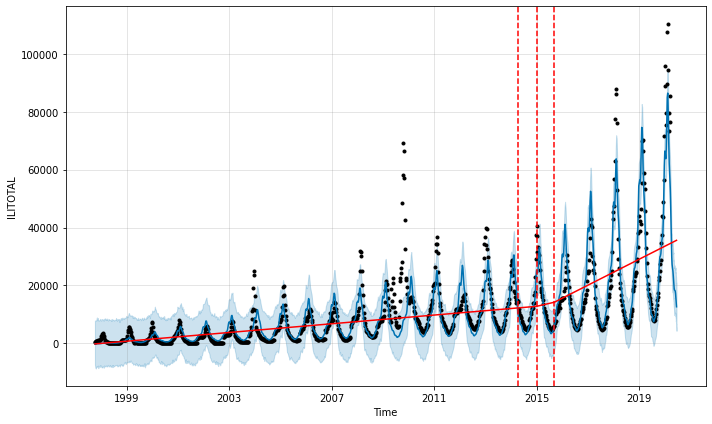

In [216]:
# Note that H1N1 outbreak and increased volumn of patients break the forecast
fig1 = m_ILI.plot(forecast, xlabel="Time", ylabel=y_name)
# Uncomment to see where the trend line changes
# a=add_changepoints_to_plot(fig1.gca(), m, forecast)
a=add_changepoints_to_plot(fig1.gca(), m_ILI, forecast)

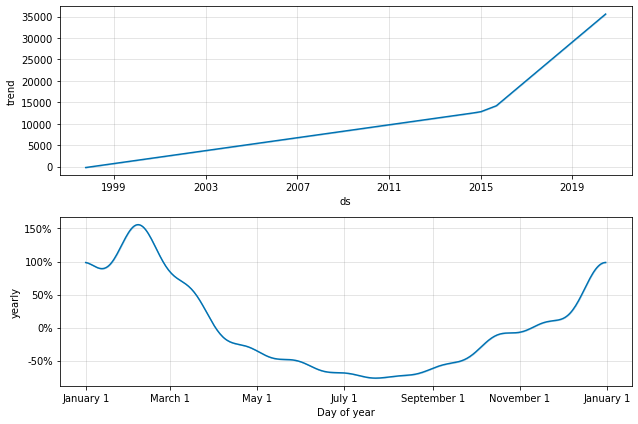

In [245]:
# Plot the yearly trends and monthly seasonality component
fig2 = m_ILI.plot_components(forecast)
ax = plt.gca()
line = ax.lines[0]
y_test = line.get_ydata()
x_test = line.get_xdata()

df = pd.DataFrame(data = {'date': x_test, 'seasonality': y_test})
df.to_csv('seasonality_nationwide.csv')

In [229]:
# m_ILI.__dict__.keys()
# import inspect
# inspect.getmembers(m_ILI, predicate=inspect.ismethod)

m_ILI.make_seasonality_features(dates, 365, 10)

[('__init__',
  <bound method Prophet.__init__ of <fbprophet.forecaster.Prophet object at 0x000001F1746F53C8>>),
 ('_load_stan_backend',
  <bound method Prophet._load_stan_backend of <fbprophet.forecaster.Prophet object at 0x000001F1746F53C8>>),
 ('add_country_holidays',
  <bound method Prophet.add_country_holidays of <fbprophet.forecaster.Prophet object at 0x000001F1746F53C8>>),
 ('add_group_component',
  <bound method Prophet.add_group_component of <fbprophet.forecaster.Prophet object at 0x000001F1746F53C8>>),
 ('add_regressor',
  <bound method Prophet.add_regressor of <fbprophet.forecaster.Prophet object at 0x000001F1746F53C8>>),
 ('add_seasonality',
  <bound method Prophet.add_seasonality of <fbprophet.forecaster.Prophet object at 0x000001F1746F53C8>>),
 ('construct_holiday_dataframe',
  <bound method Prophet.construct_holiday_dataframe of <fbprophet.forecaster.Prophet object at 0x000001F1746F53C8>>),
 ('fit',
  <bound method Prophet.fit of <fbprophet.forecaster.Prophet object at 0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 31.3 s
Complete: Seasonality mode  multiplicative , scale  0.05


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 30.9 s
Complete: Seasonality mode  multiplicative , scale  0.1


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 40.9 s
Complete: Seasonality mode  multiplicative , scale  0.25


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 1min 11s
Complete: Seasonality mode  multiplicative , scale  0.5


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 1min 30s
Complete: Seasonality mode  multiplicative , scale  1


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 25.4 s
Complete: Seasonality mode  additive , scale  0.05


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 30.5 s
Complete: Seasonality mode  additive , scale  0.1


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 35.6 s
Complete: Seasonality mode  additive , scale  0.25


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 57.5 s
Complete: Seasonality mode  additive , scale  0.5


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00


Wall time: 1min 12s
Complete: Seasonality mode  additive , scale  1


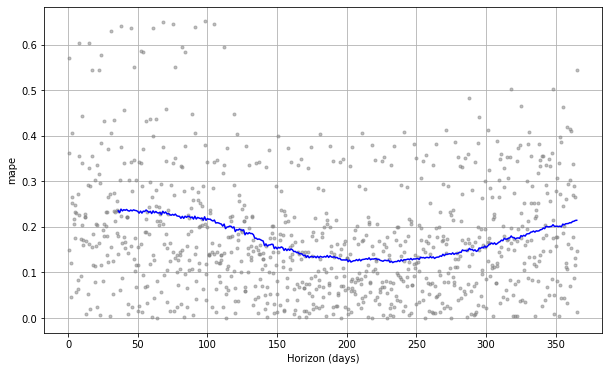

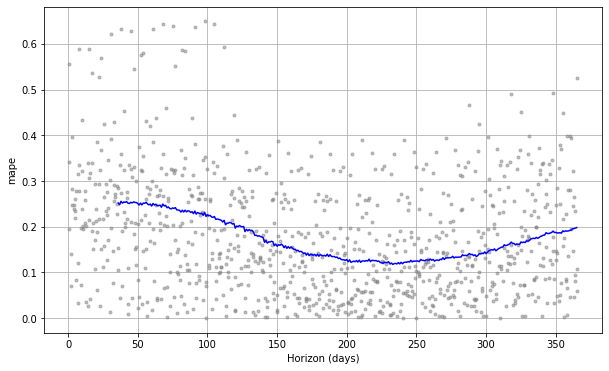

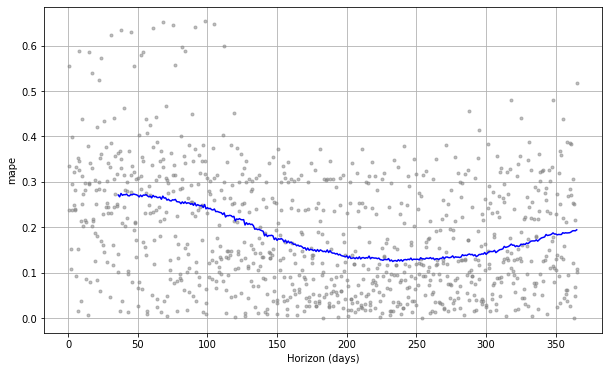

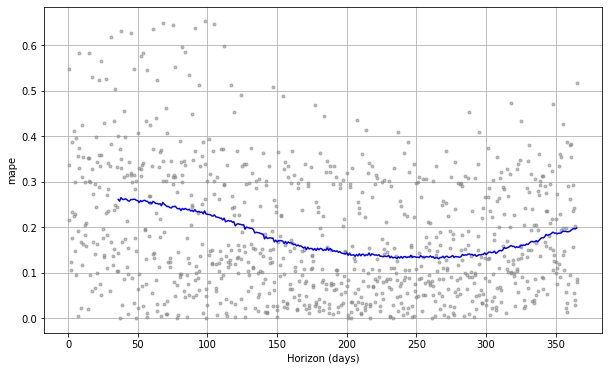

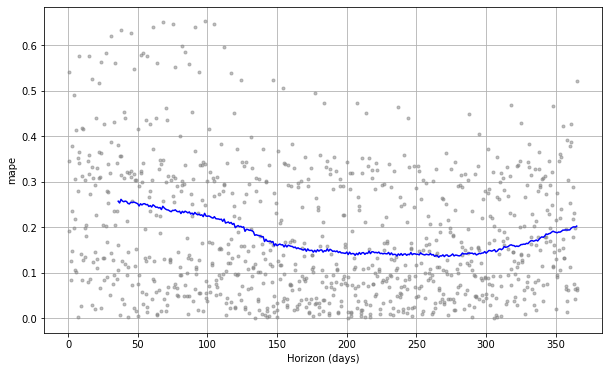

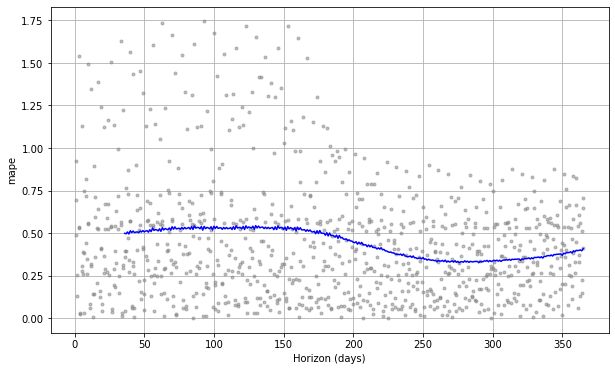

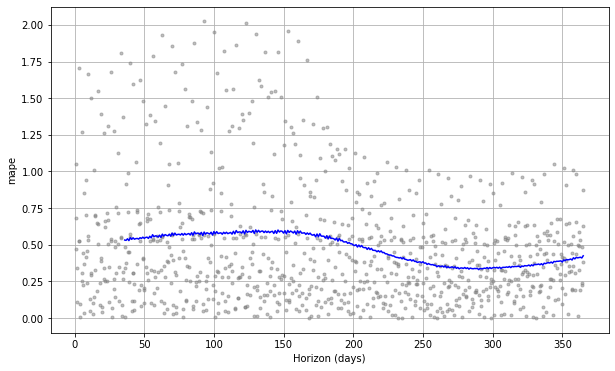

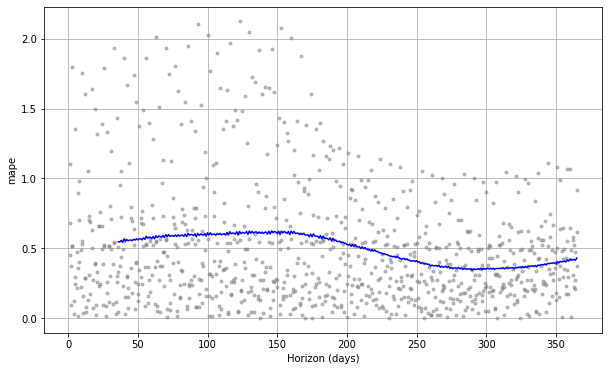

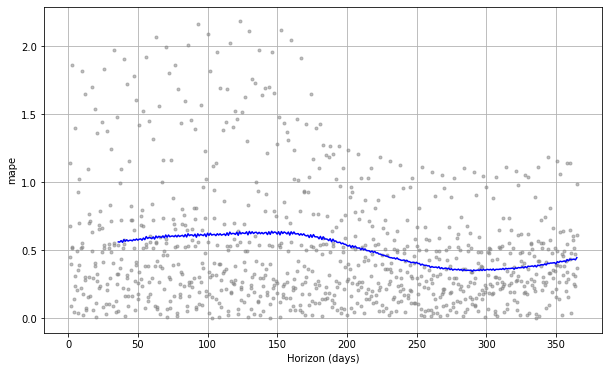

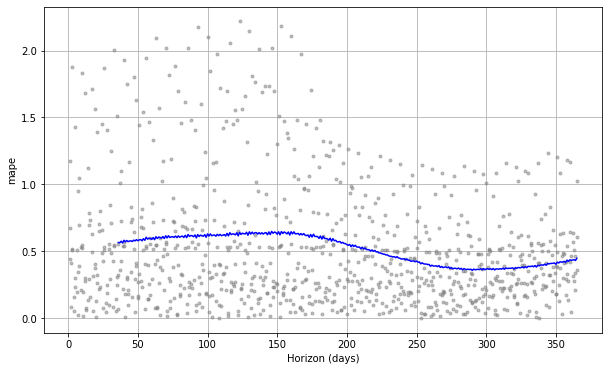

In [170]:
# assess the performance with different settings
changepoint_prior_scale_list = [0.05, 0.1, 0.25, 0.5, 1]
seasonality_mode_list={'multiplicative', 'additive'}

m_ILI_diffSettings = []
df_cv_diffSettings = []
for i, mode in enumerate(seasonality_mode_list):
    m_ILI_diffSettings.append([])
    df_cv_diffSettings.append([])
    for j, scale in enumerate(changepoint_prior_scale_list):
        m_temp = Prophet(changepoint_prior_scale = scale, seasonality_mode = mode)
        m_temp.fit(df_ILI)
        m_ILI_diffSettings[i].append(m_temp)
        
        %time df_cv_temp = cross_validation(m_temp, initial='%i days' % (20 * 365), period='30 days', horizon = '365 days')
        df_cv_diffSettings[i].append(df_cv_temp)
        plot_cross_validation_metric(df_cv_temp, metric='mape')
        
        print("Complete: Seasonality mode ", mode, ", scale ", scale)

In [171]:
# get performance metrics
df_p_ILI = []
mape_ILI = []
for i in range(len(df_cv_diffSettings)):
    df_p_ILI.append([])
    mape_ILI.append([])
    for j in range(len(df_cv_diffSettings[i])):
        df_p_ILI_temp = performance_metrics(df_cv_diffSettings[i][j])
        df_p_ILI[i].append(df_p_ILI_temp)
        mape_ILI[i].append(df_p_ILI_temp['mape'])
        
print(df_p_ILI[0][0])
print(mape_ILI[0][0])


     horizon           mse          rmse           mae      mape     mdape  \
0    36 days  2.217612e+08  14891.647586   8852.418380  0.235062  0.214570   
1    37 days  2.051433e+08  14322.825216   8446.130590  0.231172  0.214570   
2    38 days  2.329545e+08  15262.847876   8986.268541  0.238904  0.221644   
3    39 days  2.281110e+08  15103.343504   8760.208422  0.234969  0.214570   
4    40 days  2.358501e+08  15357.411116   9015.746721  0.237628  0.216825   
..       ...           ...           ...           ...       ...       ...   
325 361 days  2.422893e+08  15565.644023  10252.042697  0.208853  0.198145   
326 362 days  2.414282e+08  15537.960139  10287.878849  0.211616  0.198655   
327 363 days  2.447605e+08  15644.824086  10402.955968  0.212248  0.198655   
328 364 days  2.463117e+08  15694.321758  10486.585088  0.213975  0.203591   
329 365 days  2.688577e+08  16396.881964  10879.615232  0.214406  0.203591   

     coverage  
0    0.695652  
1    0.710145  
2    0.695652  

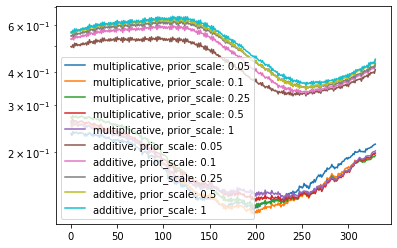

In [175]:
for i, mode in enumerate(seasonality_mode_list):
    for j, scale in enumerate(changepoint_prior_scale_list):
        lbl = "{}, prior_scale: {}".format(mode, scale)
        plt.plot(range(len(mape_ILI[i][j])), mape_ILI[i][j], label = lbl)
plt.legend()
plt.yscale("log")


(0.11, 0.7)

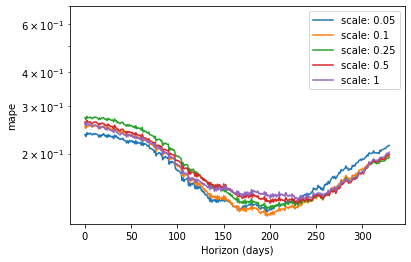

In [200]:
i = 0
mode = 'multiplicative'
for j, scale in enumerate(changepoint_prior_scale_list):
    lbl = "scale: {}".format(scale)
    plt.plot(range(len(mape_ILI[i][j])), mape_ILI[i][j], label = lbl)
plt.legend()
plt.yscale("log")
plt.ylabel('mape')
plt.xlabel('Horizon (days)')
plt.ylim(0.11, 0.7)

(0.11, 0.7)

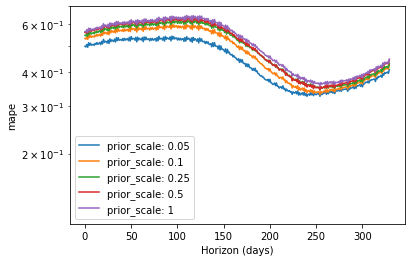

In [199]:
i = 1
mode = 'additive'
for j, scale in enumerate(changepoint_prior_scale_list):
    lbl = "prior_scale: {}".format(scale)
    plt.plot(range(len(mape_ILI[i][j])), mape_ILI[i][j], label = lbl)
plt.legend()
plt.yscale("log")
plt.ylabel('mape')
plt.xlabel('Horizon (days)')
plt.ylim(0.11, 0.7)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 1min 21s
Complete: Seasonality mode  multiplicative , scale  0.001


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 24.6 s
Complete: Seasonality mode  multiplicative , scale  0.0025


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 24.8 s
Complete: Seasonality mode  multiplicative , scale  0.005


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 26.3 s
Complete: Seasonality mode  multiplicative , scale  0.01


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 26.7 s
Complete: Seasonality mode  multiplicative , scale  0.025


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00


Wall time: 30.8 s
Complete: Seasonality mode  multiplicative , scale  0.05


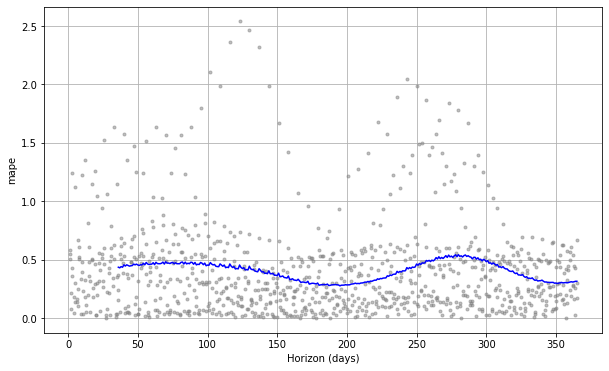

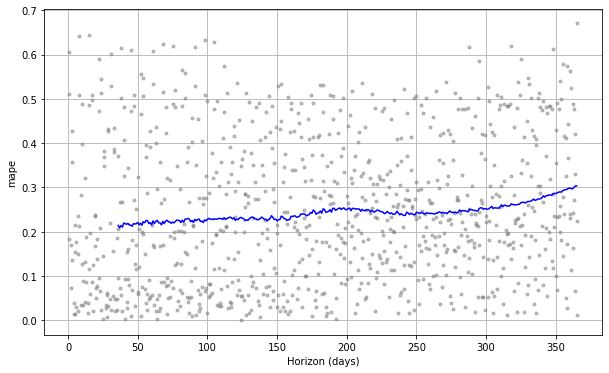

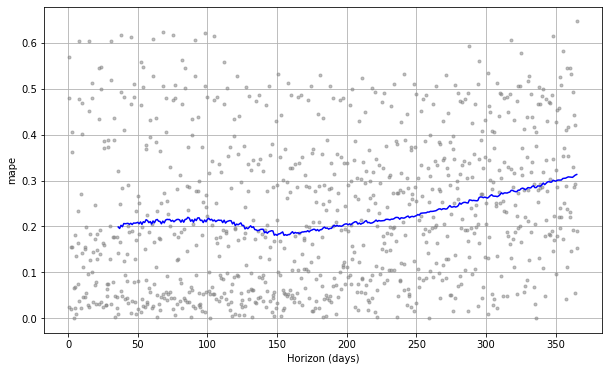

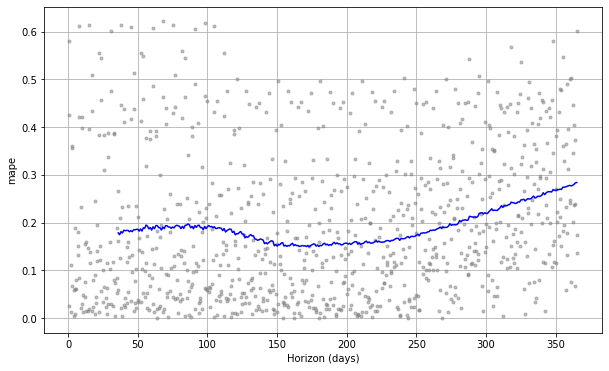

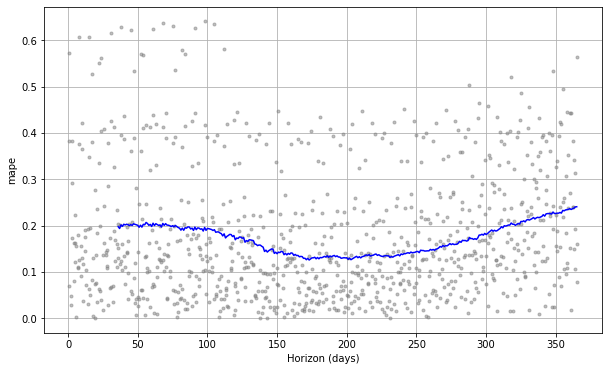

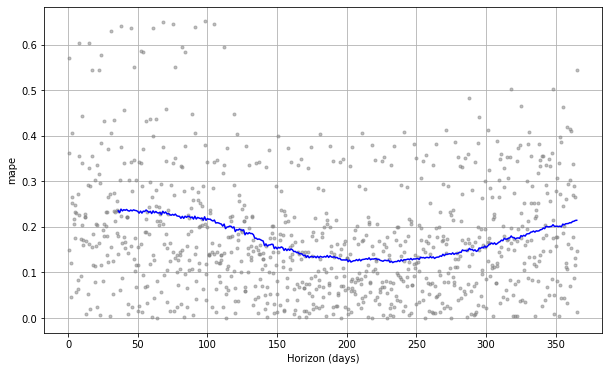

In [201]:
# assess the performance with different settings
changepoint_prior_scale_list = [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05]
seasonality_mode_list={'multiplicative'}

m_ILI_diffSettings2 = []
df_cv_diffSettings2 = []
for i, mode in enumerate(seasonality_mode_list):
    m_ILI_diffSettings2.append([])
    df_cv_diffSettings2.append([])
    for j, scale in enumerate(changepoint_prior_scale_list):
        m_temp = Prophet(changepoint_prior_scale = scale, seasonality_mode = mode)
        m_temp.fit(df_ILI)
        m_ILI_diffSettings2[i].append(m_temp)
        
        %time df_cv_temp = cross_validation(m_temp, initial='%i days' % (20 * 365), period='30 days', horizon = '365 days')
        df_cv_diffSettings2[i].append(df_cv_temp)
        plot_cross_validation_metric(df_cv_temp, metric='mape')
        
        print("Complete: Seasonality mode ", mode, ", scale ", scale)

In [208]:
# get performance metrics
df_p_ILI2 = []
mape_ILI2 = []
for i in range(len(df_cv_diffSettings2)):
    df_p_ILI2.append([])
    mape_ILI2.append([])
    for j in range(len(df_cv_diffSettings2[i])):
        df_p_ILI_temp = performance_metrics(df_cv_diffSettings2[i][j])
        df_p_ILI2[i].append(df_p_ILI_temp)
        mape_ILI2[i].append(df_p_ILI_temp['mape'])

(0.11, 0.7)

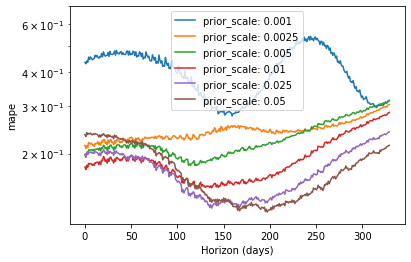

In [209]:
i = 0
mode = 'multiplicative'
for j, scale in enumerate(changepoint_prior_scale_list):
    lbl = "prior_scale: {}".format(scale)
    plt.plot(range(len(mape_ILI2[i][j])), mape_ILI2[i][j], label = lbl)
plt.legend()
plt.yscale("log")
plt.ylabel('mape')
plt.xlabel('Horizon (days)')
plt.ylim(0.11, 0.7)

## For H1N1

In [49]:
# settings for prophet
# changepoint_prior_scale=1 # default
changepoint_prior_scale=0.5
seasonality_mode='additive' # default
#seasonality_mode='multiplicative' # 'additive' default

In [50]:
# define df_ILI, which includes a total number of cases of ILI in US
df_eachVirus = pd.read_csv(f"{homedir}/data/us/flu/cases/WHO_cases_age_groupings_virus_strains.csv")
df_eachVirus["total"] = df_eachVirus["0-4 yr"] + df_eachVirus["5-24 yr"] + df_eachVirus["25-64 yr"] + df_eachVirus["65+ yr"]
df_eachVirus = df_eachVirus.rename(columns={"Year": "YEAR", " Week": "WEEK", " Virus": "Virus"}) 
    # the column names 'Week' and 'Virus' include space in the beginning, so remove it. Also, change 'year' and 'week' into upper cases
df_eachVirus.head()

,YEAR,WEEK,Virus,0-4 yr,5-24 yr,25-64 yr,65+ yr,total
0,2019,40,A (H3),4,10,15,20,49
1,2019,41,A (H3),2,12,12,27,53
2,2019,42,A (H3),14,15,20,26,75
3,2019,43,A (H3),4,13,23,22,62
4,2019,44,A (H3),7,13,16,17,53


In [51]:
for col in df_eachVirus.columns: 
    print(col) 
df_eachVirus['Virus'].unique()

YEAR
WEEK
Virus
0-4 yr
5-24 yr
25-64 yr
65+ yr
total


array(['A (H3)', 'A (H1N1)pdm09', 'A (Subtyping not Performed)',
       'B (Victoria Lineage)', 'B (Yamagata Lineage)',
       'B (Lineage Unspecified)', 'H3N2v', 'A (Unable to Subtype)',
       'A (H1)'], dtype=object)

In [52]:
# change the structure of df_ILI for prophet
y_name = "total"
df_H1N1 = prophet_changeDfStructure(df_eachVirus, y_name, virusType={'A (H1N1)pdm09'})
df_H1N1.tail()

,YEAR,WEEK,Virus,0-4 yr,5-24 yr,25-64 yr,65+ yr,total,ds,y
3382,2009,35,A (H1N1)pdm09,308,864,534,33,1739,2009-08-31,1739
3383,2009,36,A (H1N1)pdm09,193,620,345,20,1178,2009-09-07,1178
3384,2009,37,A (H1N1)pdm09,191,605,344,19,1159,2009-09-14,1159
3385,2009,38,A (H1N1)pdm09,207,947,343,12,1509,2009-09-21,1509
3386,2009,39,A (H1N1)pdm09,170,845,348,24,1387,2009-09-28,1387


In [53]:
# train prophet
m_H1N1 = Prophet(changepoint_prior_scale = changepoint_prior_scale, seasonality_mode = seasonality_mode)
m_H1N1.fit(df_H1N1)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [54]:
# make predictions
future = m_H1N1.make_future_dataframe(periods=90)

forecast = m_H1N1.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
679,2020-06-10,627.353137,-236.294482,1197.702724,550.718489,696.298915,-122.024581,-122.024581,-122.024581,-122.024581,-122.024581,-122.024581,0.0,0.0,0.0,505.328556
680,2020-06-11,627.926105,-174.296761,1184.178079,549.867710,698.400413,-117.749246,-117.749246,-117.749246,-117.749246,-117.749246,-117.749246,0.0,0.0,0.0,510.176859
681,2020-06-12,628.499072,-162.610251,1179.124583,549.016932,700.518006,-113.806103,-113.806103,-113.806103,-113.806103,-113.806103,-113.806103,0.0,0.0,0.0,514.692969
682,2020-06-13,629.072040,-153.914646,1179.016798,547.535180,701.445100,-110.171736,-110.171736,-110.171736,-110.171736,-110.171736,-110.171736,0.0,0.0,0.0,518.900303
683,2020-06-14,629.645007,-171.386851,1202.419438,546.573899,703.608927,-106.814348,-106.814348,-106.814348,-106.814348,-106.814348,-106.814348,0.0,0.0,0.0,522.830659


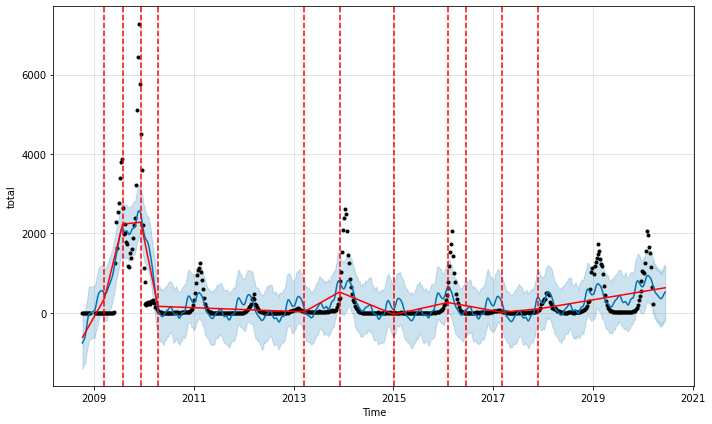

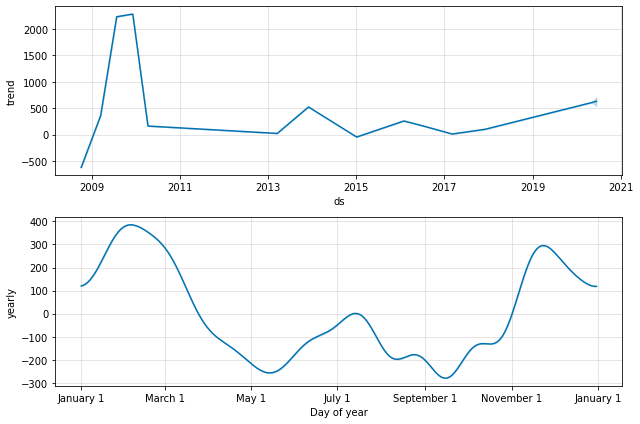

In [55]:
# Note that H1N1 outbreak and increased volumn of patients break the forecast
fig1 = m_H1N1.plot(forecast, xlabel="Time", ylabel=y_name)
# Uncomment to see where the trend line changes
# a=add_changepoints_to_plot(fig1.gca(), m, forecast)
a=add_changepoints_to_plot(fig1.gca(), m_H1N1, forecast)

# Plot the yearly trends and monthly seasonality component
fig2 = m_H1N1.plot_components(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-10-18 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 12.6 s
Complete: Seasonality mode  multiplicative , scale  0.05


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-10-18 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 10.2 s
Complete: Seasonality mode  multiplicative , scale  0.1


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-10-18 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 11.1 s
Complete: Seasonality mode  multiplicative , scale  0.25


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-10-18 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 14.9 s
Complete: Seasonality mode  multiplicative , scale  0.5


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-10-18 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 41.7 s
Complete: Seasonality mode  multiplicative , scale  1


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-10-18 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 7.7 s
Complete: Seasonality mode  additive , scale  0.05


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-10-18 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 8.56 s
Complete: Seasonality mode  additive , scale  0.1


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-10-18 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 10.5 s
Complete: Seasonality mode  additive , scale  0.25


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-10-18 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 16.2 s
Complete: Seasonality mode  additive , scale  0.5


INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-10-18 00:00:00 and 2019-03-17 00:00:00


Wall time: 17.4 s
Complete: Seasonality mode  additive , scale  1


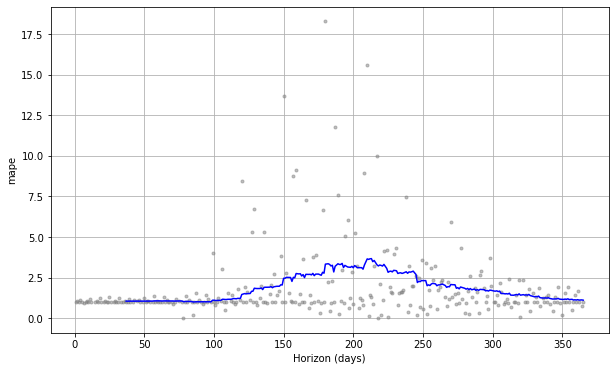

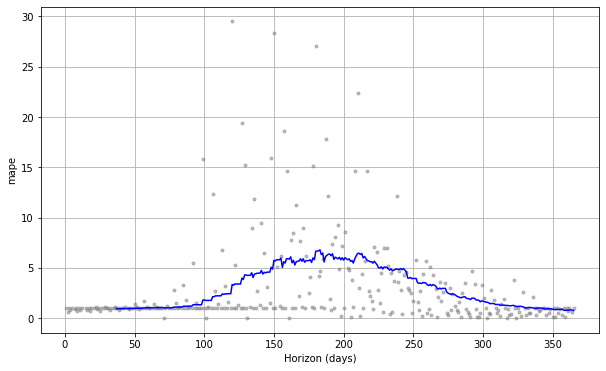

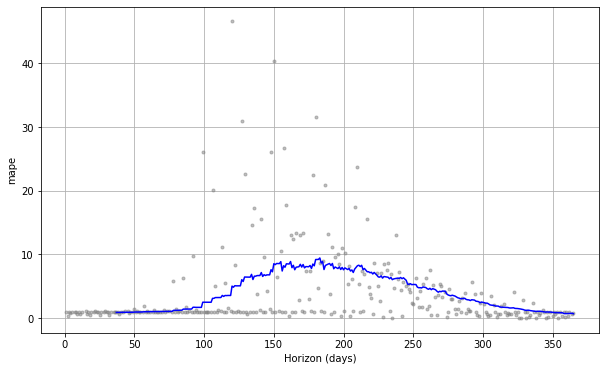

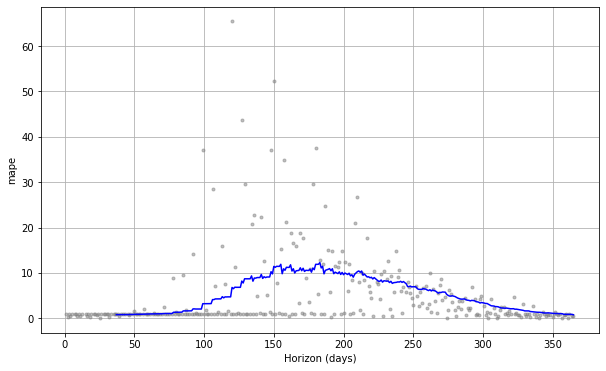

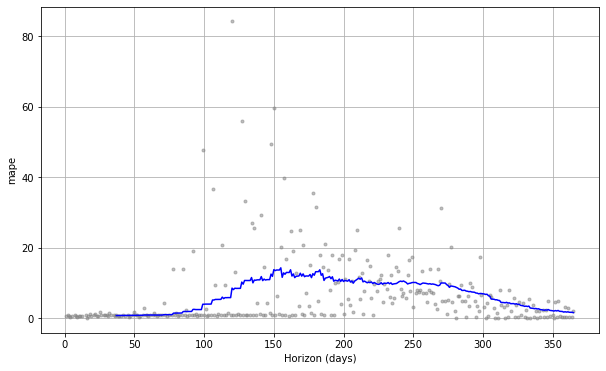

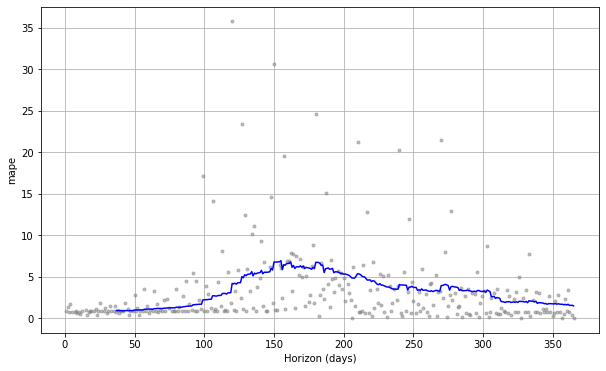

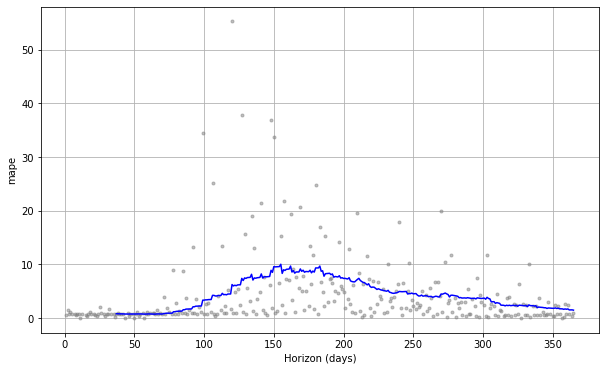

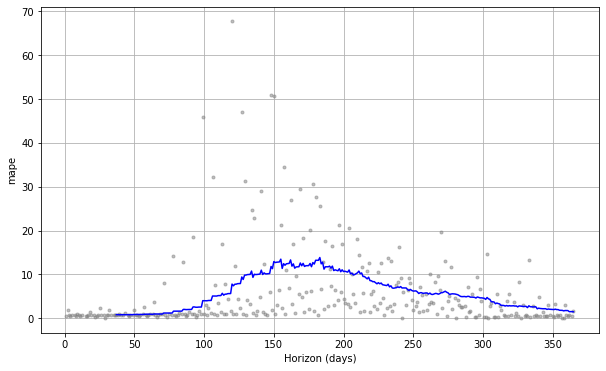

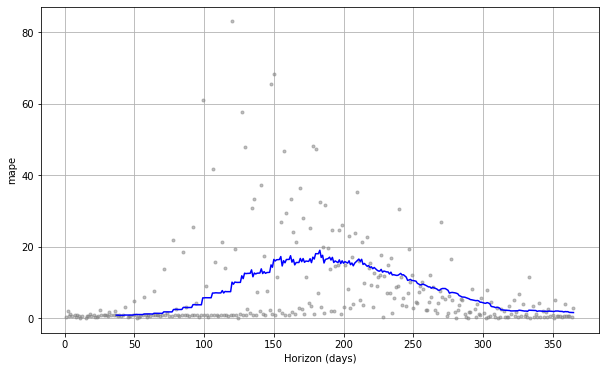

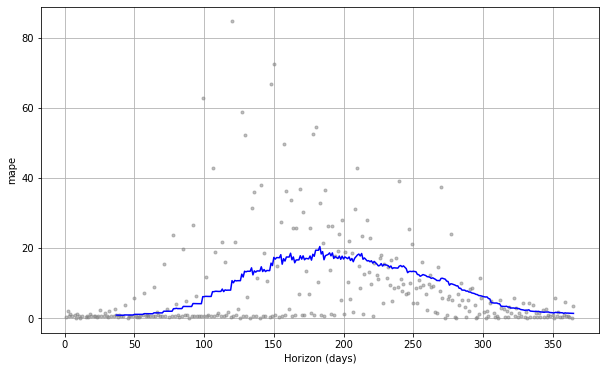

In [177]:
# assess the performance with different settings
changepoint_prior_scale_list = [0.05, 0.1, 0.25, 0.5, 1]
seasonality_mode_list={'multiplicative', 'additive'}

m_H1N1_diffSettings = []
df_cv_H1N1_diffSettings = []
for i, mode in enumerate(seasonality_mode_list):
    m_H1N1_diffSettings.append([])
    df_cv_H1N1_diffSettings.append([])
    for j, scale in enumerate(changepoint_prior_scale_list):
        m_temp = Prophet(changepoint_prior_scale = scale, seasonality_mode = mode)
        m_temp.fit(df_H1N1)
        m_H1N1_diffSettings[i].append(m_temp)
        
        %time df_cv_temp = cross_validation(m_temp, initial='%i days' % (10 * 365), period='30 days', horizon = '365 days')
        df_cv_H1N1_diffSettings[i].append(df_cv_temp)
        plot_cross_validation_metric(df_cv_temp, metric='mape')
        
        print("Complete: Seasonality mode ", mode, ", scale ", scale)

In [178]:
# get performance metrics
df_p_H1N1 = []
mape_H1N1 = []
for i in range(len(df_cv_H1N1_diffSettings)):
    df_p_H1N1.append([])
    mape_H1N1.append([])
    for j in range(len(df_cv_H1N1_diffSettings[i])):
        df_p_H1N1_temp = performance_metrics(df_cv_H1N1_diffSettings[i][j])
        df_p_H1N1[i].append(df_p_H1N1_temp)
        mape_H1N1[i].append(df_p_H1N1_temp['mape'])
        
print(df_p_H1N1[0][0])
print(mape_H1N1[0][0])

     horizon            mse        rmse         mae      mape     mdape  \
0    37 days  955581.852063  977.538670  819.215522  1.053763  1.010794   
1    38 days  939788.010990  969.426640  809.740841  1.054093  1.011530   
2    39 days  941937.385834  970.534588  813.900172  1.057351  1.011530   
3    40 days  923449.459517  960.962777  807.644638  1.057634  1.012023   
4    42 days  984734.019188  992.337654  849.481887  1.053104  1.011530   
..       ...            ...         ...         ...       ...       ...   
275 360 days  895022.088903  946.056071  654.435247  1.123122  1.005192   
276 361 days  861730.500019  928.294404  623.221018  1.144384  1.006517   
277 362 days  894176.676216  945.609156  654.722562  1.119449  1.006517   
278 364 days  898660.218612  947.976908  662.134373  1.129480  1.006517   
279 365 days  899899.029731  948.630081  665.509665  1.113345  1.006517   

     coverage  
0    0.387097  
1    0.387097  
2    0.387097  
3    0.387097  
4    0.354839  
.. 

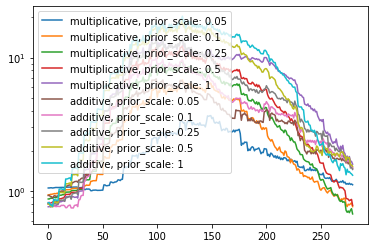

In [179]:
for i, mode in enumerate(seasonality_mode_list):
    for j, scale in enumerate(changepoint_prior_scale_list):
        lbl = "{}, prior_scale: {}".format(mode, scale)
        plt.plot(range(len(mape_H1N1[i][j])), mape_H1N1[i][j], label = lbl)
plt.legend()
plt.yscale("log")


## For Influenza A

In [57]:
# settings for prophet
# changepoint_prior_scale=1 # default
changepoint_prior_scale=0.5
#seasonality_mode='additive' # default
seasonality_mode='multiplicative'

In [130]:
# define df_ILI, which includes a total number of cases of ILI in US
df_eachVirus = pd.read_csv(f"{homedir}/data/us/flu/cases/WHO_cases_age_groupings_virus_strains.csv")
df_eachVirus["total"] = df_eachVirus["0-4 yr"] + df_eachVirus["5-24 yr"] + df_eachVirus["25-64 yr"] + df_eachVirus["65+ yr"]
df_eachVirus = df_eachVirus.rename(columns={"Year": "YEAR", " Week": "WEEK", " Virus": "Virus"}) 
    # the column names 'Week' and 'Virus' include space in the beginning, so remove it. Also, change 'year' and 'week' into upper cases
df_eachVirus.head()

,YEAR,WEEK,Virus,0-4 yr,5-24 yr,25-64 yr,65+ yr,total
0,2019,40,A (H3),4,10,15,20,49
1,2019,41,A (H3),2,12,12,27,53
2,2019,42,A (H3),14,15,20,26,75
3,2019,43,A (H3),4,13,23,22,62
4,2019,44,A (H3),7,13,16,17,53


In [116]:
for col in df_eachVirus.columns: 
    print(col) 
df_eachVirus['Virus'].unique()

YEAR
WEEK
Virus
0-4 yr
5-24 yr
25-64 yr
65+ yr
total


array(['A (H3)', 'A (H1N1)pdm09', 'A (Subtyping not Performed)',
       'B (Victoria Lineage)', 'B (Yamagata Lineage)',
       'B (Lineage Unspecified)', 'H3N2v', 'A (Unable to Subtype)',
       'A (H1)'], dtype=object)

In [147]:
# change the structure of df_ILI for prophet
y_name = "total"
virusType = {'A (H3)', 'A (H1N1)pdm09', 'A (Subtyping not Performed)','A (Unable to Subtype)','A (H1)'}

df_fluA = df_eachVirus.loc[df_eachVirus['Virus'].isin(virusType)]
df_fluA = df_fluA.groupby(['YEAR', 'WEEK']).sum()
df_fluA.reset_index(inplace=True)

df_fluA = prophet_changeDfStructure(df_fluA, y_name)

# df_fluA = prophet_changeDfStructure(df_eachVirus, y_name, virusType=virusType)
# df_fluA = df_fluA.groupby(['YEAR', 'WEEK']).sum()
# df_fluA.reset_index(inplace=True)

df_fluA.tail()
#df_fluA.to_csv('test.csv')

,YEAR,WEEK,0-4 yr,5-24 yr,25-64 yr,65+ yr,total,ds,y
1167,2020,7,146,422,781,391,1740,2020-02-17,1740
1168,2020,8,156,347,770,404,1677,2020-02-24,1677
1169,2020,9,128,263,538,346,1275,2020-03-02,1275
1170,2020,10,84,152,331,197,764,2020-03-09,764
1171,2020,11,32,62,119,76,289,2020-03-16,289


In [148]:
# train prophet
m_fluA = Prophet(changepoint_prior_scale = changepoint_prior_scale, seasonality_mode = seasonality_mode)
m_fluA.fit(df_fluA)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [149]:
# make predictions
future = m_fluA.make_future_dataframe(periods=90)

forecast = m_fluA.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1253,2020-06-10,755.585581,-368.518415,1113.976510,753.281826,755.878166,-0.531724,-0.531724,-0.531724,-0.531724,-0.531724,-0.531724,0.0,0.0,0.0,353.822815
1254,2020-06-11,755.722840,-479.649133,1208.449870,753.387504,756.129701,-0.526513,-0.526513,-0.526513,-0.526513,-0.526513,-0.526513,0.0,0.0,0.0,357.824569
1255,2020-06-12,755.860098,-443.964399,1113.213595,753.493182,756.294513,-0.522708,-0.522708,-0.522708,-0.522708,-0.522708,-0.522708,0.0,0.0,0.0,360.765880
1256,2020-06-13,755.997357,-450.713071,1200.158107,753.598860,756.541336,-0.520161,-0.520161,-0.520161,-0.520161,-0.520161,-0.520161,0.0,0.0,0.0,362.756680
1257,2020-06-14,756.134616,-393.732661,1216.211461,753.704538,756.900627,-0.518703,-0.518703,-0.518703,-0.518703,-0.518703,-0.518703,0.0,0.0,0.0,363.925174


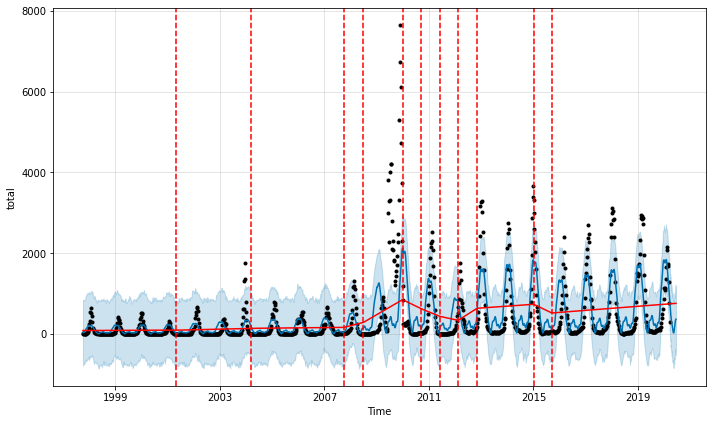

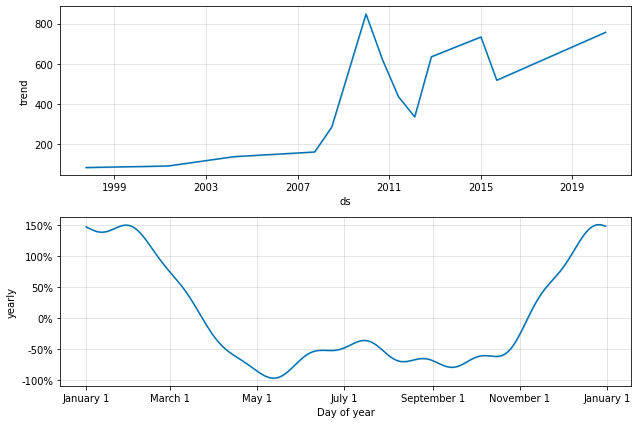

In [151]:
# Note that H1N1 outbreak and increased volumn of patients break the forecast
fig1 = m_fluA.plot(forecast, xlabel="Time", ylabel=y_name)
# Uncomment to see where the trend line changes
# a=add_changepoints_to_plot(fig1.gca(), m, forecast)
a=add_changepoints_to_plot(fig1.gca(), m_fluA, forecast)

# Plot the yearly trends and monthly seasonality component
fig2 = m_fluA.plot_components(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 27.3 s
Complete: Seasonality mode  multiplicative , scale  0.05


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 29.4 s
Complete: Seasonality mode  multiplicative , scale  0.1


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 53.2 s
Complete: Seasonality mode  multiplicative , scale  0.25


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 1min 28s
Complete: Seasonality mode  multiplicative , scale  0.5


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 1min 55s
Complete: Seasonality mode  multiplicative , scale  1


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 27.2 s
Complete: Seasonality mode  additive , scale  0.05


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 31.2 s
Complete: Seasonality mode  additive , scale  0.1


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 48.1 s
Complete: Seasonality mode  additive , scale  0.25


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 1min 8s
Complete: Seasonality mode  additive , scale  0.5


INFO:fbprophet:Making 18 forecasts with cutoffs between 2017-10-23 00:00:00 and 2019-03-17 00:00:00


Wall time: 1min 18s
Complete: Seasonality mode  additive , scale  1


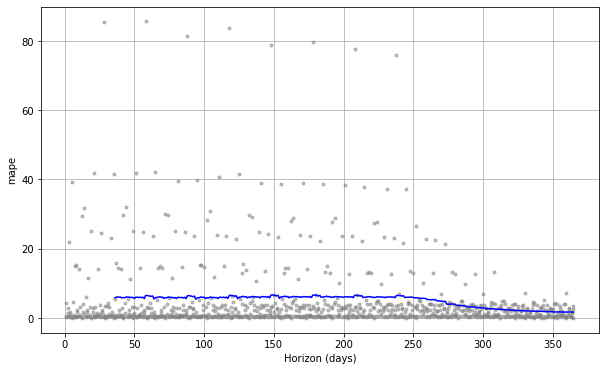

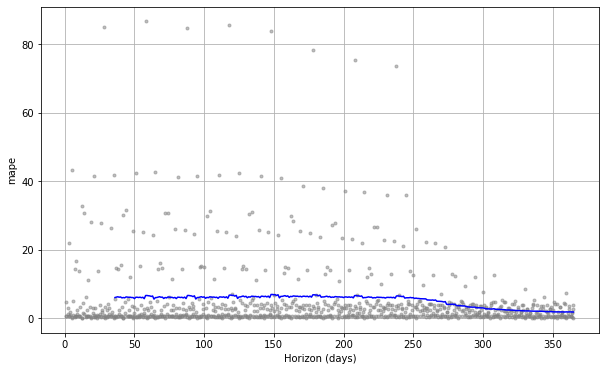

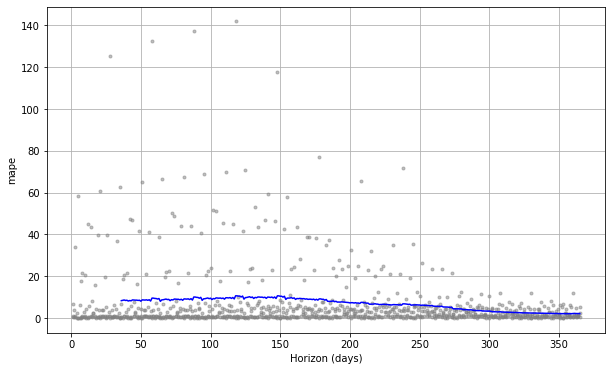

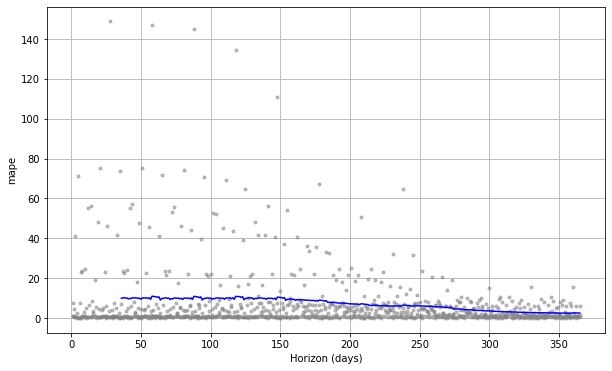

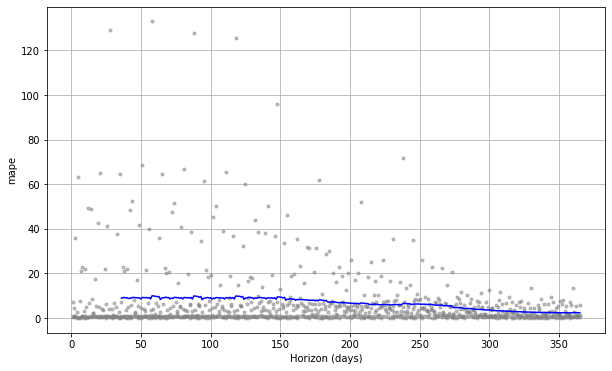

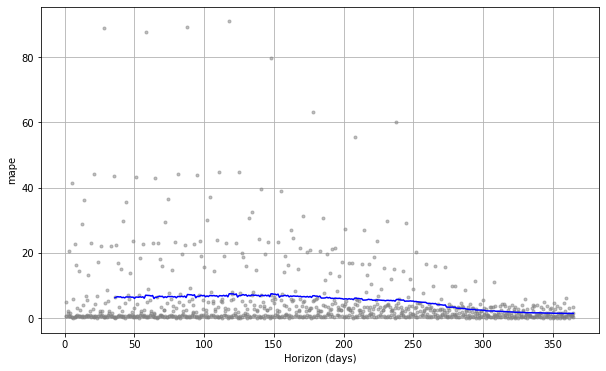

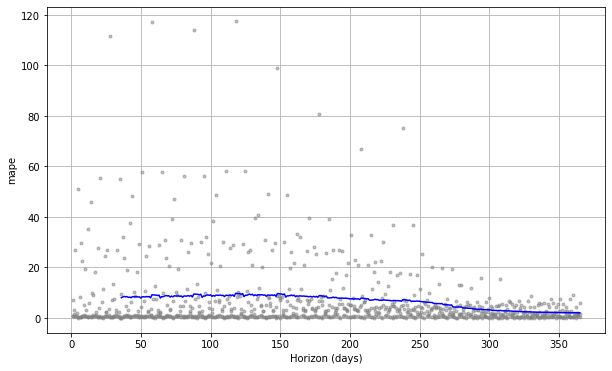

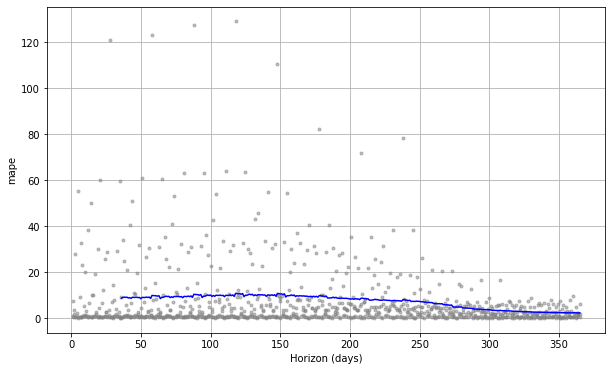

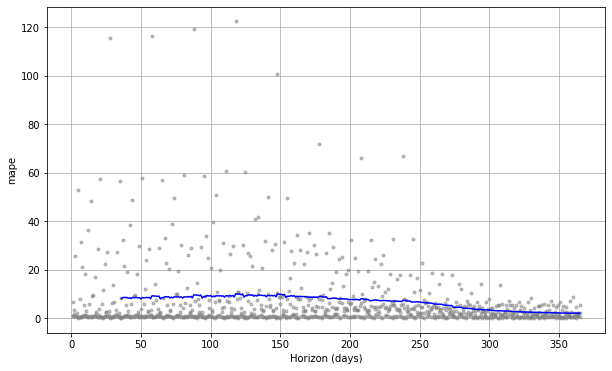

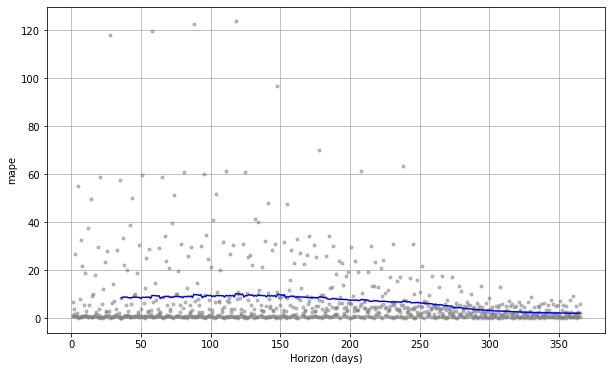

In [180]:
# assess the performance with different settings
changepoint_prior_scale_list = [0.05, 0.1, 0.25, 0.5, 1]
seasonality_mode_list={'multiplicative', 'additive'}

m_fluA_diffSettings = []
df_cv_fluA_diffSettings = []
for i, mode in enumerate(seasonality_mode_list):
    m_fluA_diffSettings.append([])
    df_cv_fluA_diffSettings.append([])
    for j, scale in enumerate(changepoint_prior_scale_list):
        m_temp = Prophet(changepoint_prior_scale = scale, seasonality_mode = mode)
        m_temp.fit(df_fluA)
        m_fluA_diffSettings[i].append(m_temp)
        
        %time df_cv_temp = cross_validation(m_temp, initial='%i days' % (20 * 365), period='30 days', horizon = '365 days')
        df_cv_fluA_diffSettings[i].append(df_cv_temp)
        plot_cross_validation_metric(df_cv_temp, metric='mape')
        
        print("Complete: Seasonality mode ", mode, ", scale ", scale)

In [181]:
# get performance metrics
df_p_fluA = []
mape_fluA = []
for i in range(len(df_cv_fluA_diffSettings)):
    df_p_fluA.append([])
    mape_fluA.append([])
    for j in range(len(df_cv_fluA_diffSettings[i])):
        df_p_fluA_temp = performance_metrics(df_cv_fluA_diffSettings[i][j])
        df_p_fluA[i].append(df_p_fluA_temp)
        mape_fluA[i].append(df_p_fluA_temp['mape'])
        
print(df_p_fluA[0][0])
print(mape_fluA[0][0])

     horizon            mse        rmse         mae      mape     mdape  \
0    36 days  555252.356945  745.152573  560.468887  5.871083  0.967696   
1    37 days  523214.871523  723.335933  544.028103  6.008129  0.967696   
2    38 days  540687.898535  735.314830  555.109203  6.112826  0.933378   
3    39 days  523976.436789  723.862167  543.863503  5.985849  0.967696   
4    40 days  562444.293912  749.962862  564.820216  6.041424  0.967696   
..       ...            ...         ...         ...       ...       ...   
325 361 days  424395.802865  651.456678  477.629075  1.720683  1.063880   
326 362 days  416283.972265  645.200722  476.109567  1.750914  1.253580   
327 363 days  428120.042832  654.308828  482.050739  1.727580  1.017876   
328 364 days  434289.238312  659.006251  483.980768  1.708699  1.017876   
329 365 days  435214.399798  659.707814  482.931748  1.701255  1.017876   

     coverage  
0    0.782609  
1    0.797101  
2    0.782609  
3    0.797101  
4    0.782609  
.. 

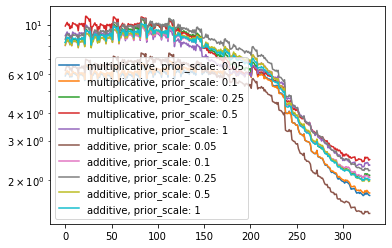

In [184]:
for i, mode in enumerate(seasonality_mode_list):
    for j, scale in enumerate(changepoint_prior_scale_list):
        lbl = "{}, prior_scale: {}".format(mode, scale)
        plt.plot(range(len(mape_fluA[i][j])), mape_fluA[i][j], label = lbl)
plt.legend()
plt.yscale("log")


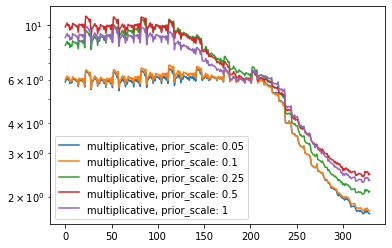

In [190]:
i = 0
mode = 'multiplicative'
for j, scale in enumerate(changepoint_prior_scale_list):
    lbl = "{}, prior_scale: {}".format(mode, scale)
    plt.plot(range(len(mape_fluA[i][j])), mape_fluA[i][j], label = lbl)
plt.legend()
plt.yscale("log")

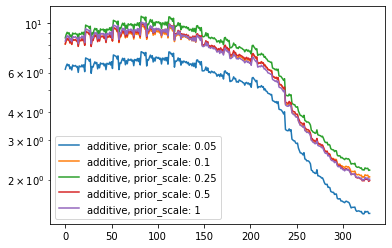

In [191]:
i = 1
mode = 'additive'
for j, scale in enumerate(changepoint_prior_scale_list):
    lbl = "{}, prior_scale: {}".format(mode, scale)
    plt.plot(range(len(mape_fluA[i][j])), mape_fluA[i][j], label = lbl)
plt.legend()
plt.yscale("log")